<h1><center>Tarea 8: AutoEncoders</center></h1>
<p><center><b>Adrián Rubén Bedón Campaña</b></center></p>
<p><center><b>Xavier Aljandro Ramos Vásconez</b></center></p>

<h4><b>Importación de librerías</b></h4>

Para la construcción del autoencoder se utilizarán las librerías: NumPy *(Construcción y Manipulación de Arreglos)*, MatPlotLib *(Elaboración de gráficas de espacio latente y gráfica de pérdida)* y PyTorch *(Base de datos MNIST y capas para la construcción del modelo)*

In [1]:
#Importación de librerías
#|-Creado por: Adrián Bedón
#|-Fecha de última modificación: 03/07/2024
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

<h4><b>Configuraciones iniciales y Extracción de Datos</b></h4>

<h5><b>Configuraciones</b></h5>
Para una ejecución más rápida del autoencoder se plantea el uso de la GPU, si la misma está disponible, caso contrario la ejecución se llevará a cabo dentro del CPU del equipo donde se ejecute.

<h5><b>Extracción de Datos</b></h5>
A partir de la librería <i>datasets</i> de <i>TorchVision</i> se descargará la base de datos <b>MNIST</b> que contiene imágenes de los dígitos del 1 al 9 en escala B/N <i>(Blanco y Negro)</i> y este será cargado dentro del modelo con el con el uso de <i>DataLoader</i>

In [2]:
#Configuraciones iniciales y Extracción de Datos
#|-Creado por: Adrián Bedón
#|-Fecha de última modificación: 03/07/2024
use_cuda = torch.cuda.is_available() #Se usa GPU si es que es posible caso contrario se usará CPU
device = torch.device("cuda" if use_cuda else "cpu")
train_kwargs = {'batch_size': 64}
if use_cuda:
    cuda_kwargs = {'num_workers': 0, 'pin_memory': True, 'shuffle': True}
    train_kwargs.update(cuda_kwargs)

#Función de transformación de las imágenes estas son aplanadas para tener una dimensión de 28*28
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST('../data', train=True, download=True, transform=transform) #Obtención del dataset

train_loader = DataLoader(dataset_train, **train_kwargs) #Carga del dataset

<h5><b>Modelo</b></h5>

El modelo que se ha construido consta de 4 capas de **Encode** y 4 capas de **Decode** todas ellas utilizan la Función de *Activación Lineal empezando en la dimesión 28\*28* y terminando en la dimensión 3 para la determinación del **Espacio Latente**, definido como el espacio en el que se encuentran todos los datos en la capa de cuello de botella y que se convierte en la única información que el decodificador puede usar para intentar reconstruir la imagen de entrada con la mayor fidelidad posible.

In [3]:
#Modelo
#|-Creado por: Adrián Bedón
#|-Fecha de última modificación: 03/07/2024
class Model(nn.Module):
    def __init__(self, in_features=28*28, out_features=3): #Definición de dimensiones de Entrada y Salida
        super(Model, self).__init__()
        self.enc1 = nn.Linear(in_features,128) #1ra Capa de Encode
        self.enc2 = nn.Linear(128, 64) #2da Capa de Encode
        self.enc3 = nn.Linear(64, 32) #3ra Capa de Encode
        self.enc4 = nn.Linear(32, out_features) #4ta Capa de Encode
        self.dec1 = nn.Linear(out_features, 32) #1ra Capa de Decode
        self.dec2 = nn.Linear(32, 64) #2da Capa de Decode
        self.dec3 = nn.Linear(64, 128) #3ra Capa de Decode
        self.dec4 = nn.Linear(128, in_features) #4ta Capa de Decode

    #Función de Ejecución implementando codificación y decodificación acompañada de la Función ReLU y Sigmoide
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = self.enc4(x)
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return torch.sigmoid(self.dec4(x))

    #Función de codificación
    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        return self.enc4(x)

#Instanciación del Modelo   
model = Model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Optimizador
print(model) #Impresión del Modelo

Model(
  (enc1): Linear(in_features=784, out_features=128, bias=True)
  (enc2): Linear(in_features=128, out_features=64, bias=True)
  (enc3): Linear(in_features=64, out_features=32, bias=True)
  (enc4): Linear(in_features=32, out_features=3, bias=True)
  (dec1): Linear(in_features=3, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=784, bias=True)
)


<h5><b>Ejecución</b></h5>

Para la ejecución de este modelo se utilizaron 300 épocas y tras cada una de ellas se calcula la pérdida promedio y la misma se agrega al arreglo de pérdidas para utilizarla en el gráfico que se construirá a continuación

In [4]:
#Ejecución
#|-Creado por: Adrián Bedón
#|-Fecha de última modificación: 03/07/2024
num_epochs = 300 #Número de épocas
losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(train_loader) #Cálculo de la pérdida promedio
    losses.append(avg_loss) #Adición de la pérdida al arreglo
    if (epoch % 10 == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}') 

Epoch [1/300], Loss: 0.057876
Epoch [11/300], Loss: 0.032600
Epoch [21/300], Loss: 0.030797
Epoch [31/300], Loss: 0.030170
Epoch [41/300], Loss: 0.029621
Epoch [51/300], Loss: 0.029316
Epoch [61/300], Loss: 0.029041
Epoch [71/300], Loss: 0.028939
Epoch [81/300], Loss: 0.028733
Epoch [91/300], Loss: 0.028650
Epoch [101/300], Loss: 0.028522
Epoch [111/300], Loss: 0.028373
Epoch [121/300], Loss: 0.028311
Epoch [131/300], Loss: 0.028288
Epoch [141/300], Loss: 0.028078
Epoch [151/300], Loss: 0.028006
Epoch [161/300], Loss: 0.028030
Epoch [171/300], Loss: 0.028007
Epoch [181/300], Loss: 0.028210
Epoch [191/300], Loss: 0.028025
Epoch [201/300], Loss: 0.027781
Epoch [211/300], Loss: 0.027887
Epoch [221/300], Loss: 0.027823
Epoch [231/300], Loss: 0.027906
Epoch [241/300], Loss: 0.027802
Epoch [251/300], Loss: 0.027816
Epoch [261/300], Loss: 0.027857
Epoch [271/300], Loss: 0.027801
Epoch [281/300], Loss: 0.027630
Epoch [291/300], Loss: 0.027544
Epoch [300/300], Loss: 0.027718


<h5><b>Gráficas</b></h5>

Para entender de mejor manera el progreso de entrenamiento del modelo se plantea la construcción de una gráfica sobre el historial de pérdidas promedio a lo largo de las **300 épocas** que se llevaron a acabo adicional se plantea la representación del **Espacio Latente 3-dimensional** para verificar la separabilidad del mismo tras las ejecuciones.

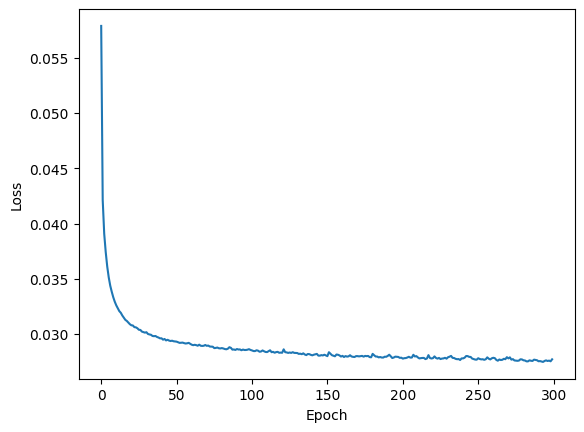

In [5]:
#Gráficas
#|-Creado por: Adrián Bedón
#|-Fecha de última modificación: 03/07/2024
plt.plot(range(len(losses)), losses) #Gráfica de pérdidas promedio
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

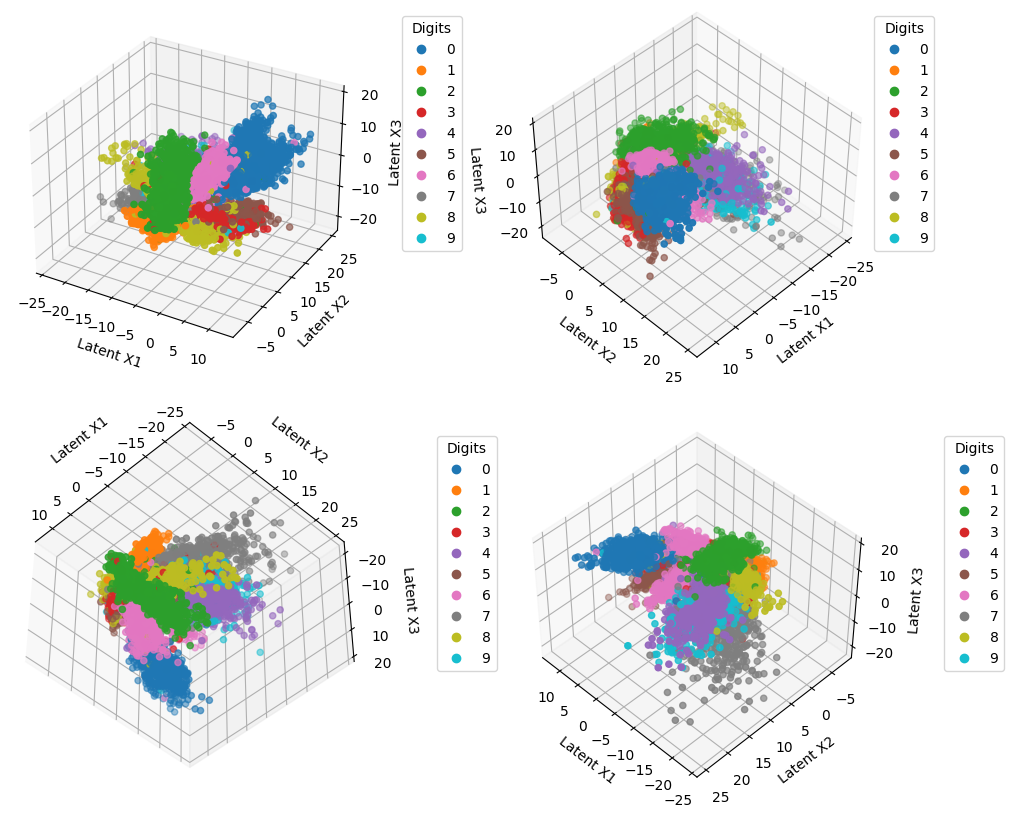

In [6]:
#Gráficas
#|-Creado por: Adrián Bedón
#|-Fecha de última modificación: 03/07/2024
with torch.no_grad():
    sample_loader = DataLoader(dataset_train, batch_size=10000, shuffle=False)
    dataiter = iter(sample_loader)
    images, labels = next(dataiter)
    images = images.view(images.size(0), -1).to(device)
    latent_codes = model.encode(images).cpu()

labels = dataset_train.targets[:10000].numpy()
axis_labels = ['Latent X1','Latent X2','Latent X3'] #Definición de los labels de los ejes del gráfico
location = 'upper left' #Ubicación de la leyenda en el gráfico

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(2,2,1, projection='3d') #Primera Gráfica de Espacio Latente 3-Dimensional
xs, ys, zs = latent_codes[:, 0].numpy(), latent_codes[:, 1].numpy(), latent_codes[:, 2].numpy()
scatter = ax1.scatter(xs, ys, zs, c=labels, cmap='tab10')
ax1.set_xlabel(axis_labels[0])
ax1.set_ylabel(axis_labels[1])
ax1.set_zlabel(axis_labels[2])

legend1 = ax1.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.1, 1), loc=location)

ax2 = fig.add_subplot(2,2,2, projection='3d') #Segunda Gráfica de Espacio Latente 3-Dimensional
xs, ys, zs = latent_codes[:, 0].numpy(), latent_codes[:, 1].numpy(), latent_codes[:, 2].numpy()
scatter = ax2.scatter(xs, ys, zs, c=labels, cmap='tab10')
ax2.set_xlabel(axis_labels[0])
ax2.set_ylabel(axis_labels[1])
ax2.set_zlabel(axis_labels[2])

legend2 = ax2.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1, 1), loc=location)
ax2.view_init(45,45) #Alteración del Ángulo de Visualización

ax3 = fig.add_subplot(2,2,3, projection='3d') #Tercera Gráfica de Espacio Latente 3-Dimensional
xs, ys, zs = latent_codes[:, 0].numpy(), latent_codes[:, 1].numpy(), latent_codes[:, 2].numpy()
scatter = ax3.scatter(xs, ys, zs, c=labels, cmap='tab10')
ax3.set_xlabel(axis_labels[0])
ax3.set_ylabel(axis_labels[1])
ax3.set_zlabel(axis_labels[2])

legend3 = ax3.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.2, 1), loc=location)
ax3.view_init(135,45) #Alteración del Ángulo de Visualización

ax4 = fig.add_subplot(2,2,4, projection='3d') #Cuarta Gráfica de Espacio Latente 3-Dimensional
xs, ys, zs = latent_codes[:, 0].numpy(), latent_codes[:, 1].numpy(), latent_codes[:, 2].numpy()
scatter = ax4.scatter(xs, ys, zs, c=labels, cmap='tab10')
ax4.set_xlabel(axis_labels[0])
ax4.set_ylabel(axis_labels[1])
ax4.set_zlabel(axis_labels[2])

legend4 = ax4.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.2, 1), loc=location)
ax4.view_init(45,135) #Alteración del Ángulo de Visualización

plt.show()

<h5><b>Conclusiones</b></h5>

<h5><b>Referencias</b></h5>

El siguiente listado muestra fuentes que se usaron de referencia adicional para la construcción del modelo AutoEncoder implementado.
- AE_mnist. (s/f). Qmul.ac.uk. Recuperado el 3 de julio de 2024, de http://www.eecs.qmul.ac.uk/~sgg/_ECS795P_/papers/WK07-8_PyTorch_Tutorial2.html
 - Linear AutoEncoder-using PyTorch-part 01. (2022, marzo 17). Kaggle.com; Kaggle. https://www.kaggle.com/code/shivamkc3/linear-autoencoder-using-pytorch-part-01
- Trencseni, M. (2021, marzo 18). Building a Pytorch Autoencoder for MNIST digits. Bytepawn - Marton Trencseni. https://bytepawn.com/building-a-pytorch-autoencoder-for-mnist-digits.html